In [ ]:
Introduction & Problem Definition

Student stress and academic performance are tightly linked — understanding which factors drive stress and which factors predict performance can inform interventions (time management programs, counseling, schedule changes).

Goal is to:

1.Explore relationships between socio-demographic, behavioral, and school variables and student outcomes.

2.Build simple predictive models for final grade (G3) and a binary pass/fail target.

3.Identify which factors most influence student performance and which could proxy stress.

Datasets chosen & why:

UCI Student Performance (Math: student-mat.csv, Portuguese: student-por.csv) — chosen because it's well-documented, contains academic outcomes (G1,G2,G3), and many potential predictors: study time, failures, absences, parental education, free time, going out, health, etc. These features can be used as proxies for stressors (absences, studytime) and protective factors (family support).

Analysis questions / hypotheses

Which factors correlate most strongly with final grade (G3)? Hypothesis: studytime, failures, absences, and goout are strong predictors.

Can we predict whether a student will pass (e.g., G3 >= 10) with > 75% accuracy using the available features?

Are certain demographic groups (sex, address, guardian) associated with higher stress proxies (higher absences, lower study time)?

In [3]:
!pip install -q pandas numpy matplotlib seaborn scikit-learn xgboost shap


import sys
import platform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import xgboost as xgb


print("Python:", sys.version)
print("Platform:", platform.platform())
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("scikit-learn:", sklearn.__version__)
print("xgboost:", xgb.__version__)


# Make plots display inline
%matplotlib inline
plt.rcParams.update({"figure.figsize": (8,5)})

Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Platform: Linux-6.6.97+-x86_64-with-glibc2.35
pandas: 2.2.2
numpy: 2.0.2
scikit-learn: 1.6.1
xgboost: 3.0.5


In [5]:
!wget -q -O student.zip "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip"
!unzip -o student.zip


import pandas as pd


df_mat = pd.read_csv('student-mat.csv', sep=';')
df_por = pd.read_csv('student-por.csv', sep=';')


print('Math shape:', df_mat.shape)
print('Por shape:', df_por.shape)

display(df_mat.head())

Archive:  student.zip
  inflating: student-mat.csv         
  inflating: student-por.csv         
  inflating: student-merge.R         
  inflating: student.txt             
Math shape: (395, 33)
Por shape: (649, 33)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [6]:
df = df_mat.copy()

print(df.info())
print(df.describe(include='all').T)


print('Missing values per column:')
print(df.isnull().sum())
print('Duplicate rows:', df.duplicated().sum())


cat_cols = ['school','sex','address','famsize','Pstatus','Mjob','Fjob','reason','guardian','schoolsup','famsup','paid','activities','nursery','higher','internet','romantic']
for c in cat_cols:
     if c in df.columns:
        df[c] = df[c].astype('category')


df['pass'] = (df['G3'] >= 10).astype(int)


df['Gavg'] = df[['G1','G2','G3']].mean(axis=1)


df['alc_avg'] = df[['Dalc','Walc']].mean(axis=1)


df['high_absence'] = (df['absences'] > df['absences'].median()).astype(int)


model_df = pd.get_dummies(df.drop(columns=['G3']), drop_first=True)


print('Prepared modeling DF shape:', model_df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

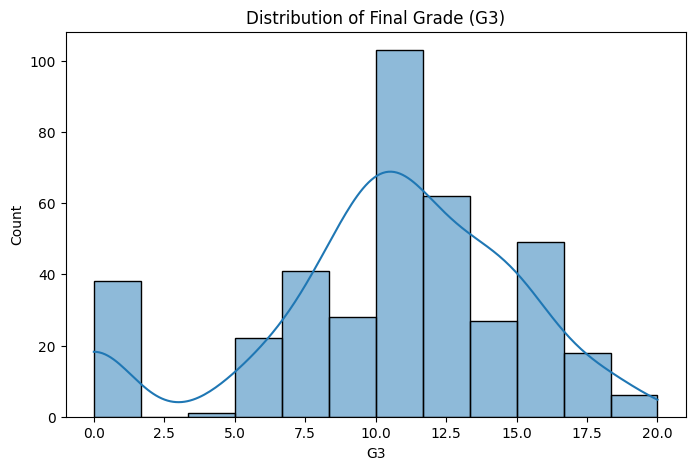

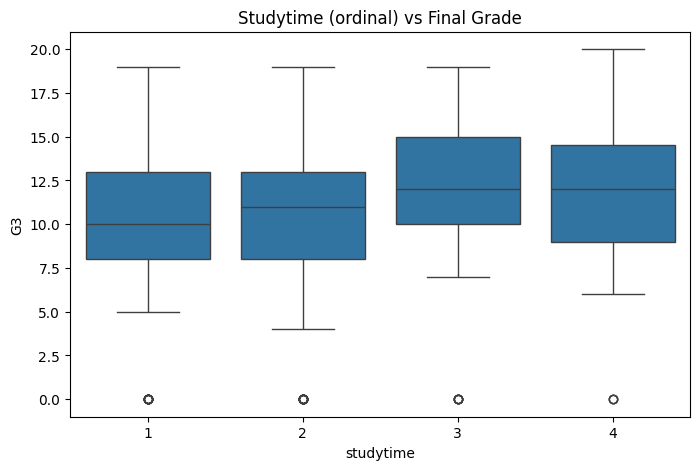

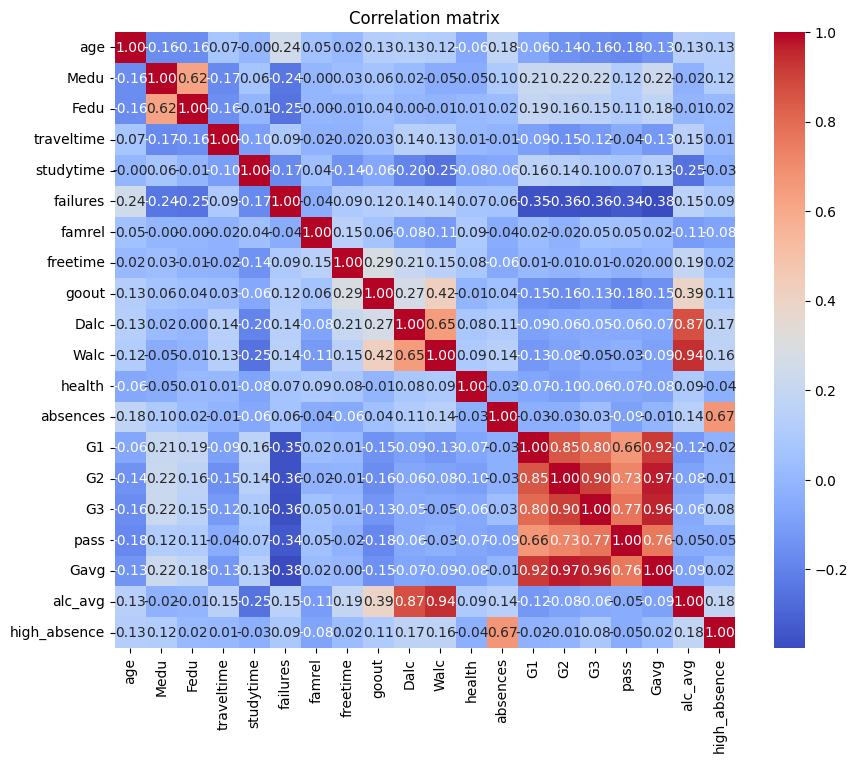

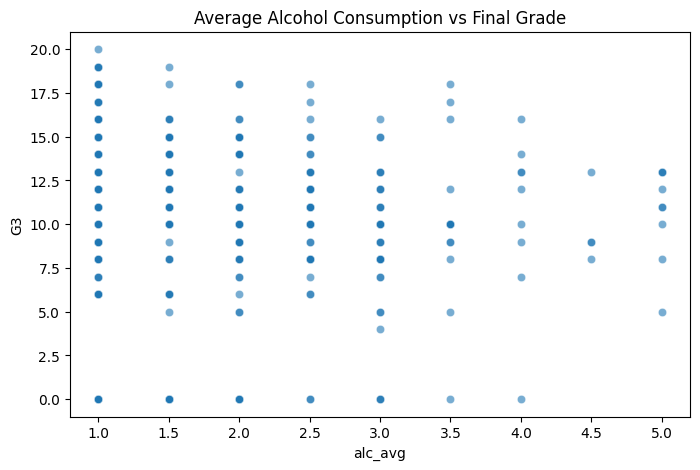

/tmp/ipython-input-1837827639.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(df.groupby('sex')[['G3','studytime','absences','alc_avg']].mean())


,G3,studytime,absences,alc_avg
sex,,,,
F,9.966346,2.278846,6.216346,1.605769
M,10.914439,1.764706,5.144385,2.197861


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure()
sns.histplot(df['G3'], bins=12, kde=True)
plt.title('Distribution of Final Grade (G3)')
plt.xlabel('G3')
plt.show()


plt.figure()
sns.boxplot(x='studytime', y='G3', data=df)
plt.title('Studytime (ordinal) vs Final Grade')
plt.show()


num_cols = df.select_dtypes(include=['int64','float64']).columns
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()


plt.figure()
sns.scatterplot(x='alc_avg', y='G3', data=df, alpha=0.6)
plt.title('Average Alcohol Consumption vs Final Grade')
plt.show()


display(df.groupby('sex')[['G3','studytime','absences','alc_avg']].mean())

In [9]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, classification_report

X = model_df.drop(columns=['pass'])

X = pd.get_dummies(df.drop(columns=['G3','pass']), drop_first=True)
y_reg = df['G3']
y_clf = df['pass']


X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
_, _, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42)


mean_pred = np.full_like(y_test_reg, y_train_reg.mean(), dtype=float)
print('Baseline RMSE:', np.sqrt(mean_squared_error(y_test_reg, mean_pred)))


rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train_reg)
pred_reg = rf.predict(X_test)
print('RF RMSE:', np.sqrt(mean_squared_error(y_test_reg, pred_reg)))
print('RF R2:', r2_score(y_test_reg, pred_reg))


feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print('Top features (regression):')
print(feat_imp.head(20))


rfc = RandomForestClassifier(n_estimators=200, random_state=42)
rfc.fit(X_train, y_train_clf)
yhat = rfc.predict(X_test)
print('Classification accuracy:', accuracy_score(y_test_clf, yhat))
print(classification_report(y_test_clf, yhat))


feat_imp_clf = pd.Series(rfc.feature_importances_, index=X.columns).sort_values(ascending=False)
print('Top features (classification):')
print(feat_imp_clf.head(20))

Baseline RMSE: 4.550180652162387
RF RMSE: 0.702380446153821
RF R2: 0.9759406411168068
Top features (regression):
Gavg            0.896253
absences        0.046138
G2              0.040493
G1              0.003470
traveltime      0.001759
age             0.000820
freetime        0.000792
Fedu            0.000699
Walc            0.000695
goout           0.000693
famrel          0.000583
health          0.000559
Medu            0.000529
alc_avg         0.000487
Fjob_other      0.000374
nursery_yes     0.000351
high_absence    0.000335
failures        0.000318
Mjob_teacher    0.000310
studytime       0.000287
dtype: float64
Classification accuracy: 0.9240506329113924
              precision    recall  f1-score   support

           0       0.84      0.96      0.90        27
           1       0.98      0.90      0.94        52

    accuracy                           0.92        79
   macro avg       0.91      0.93      0.92        79
weighted avg       0.93      0.92      0.93        79

T